## Meridional Overturning Circulation

In [1]:
%%capture 
# comment above line to see details about the run(s) displayed
from misc import *
%matplotlib inline

In [2]:
# empty parametrizable cell 

cluster_scheduler_address = None
obs_path = None
obs_suffix = None

In [3]:
# Parameters
not_casename = "placeholder-casename"
subset_kwargs = {}


## Connecting to cluster

In [4]:
from dask.distributed import Client

if cluster_scheduler_address is None:
    pass
else:
    client = Client(cluster_scheduler_address)
    
    client

In [5]:
ds = []
for c, l, p in zip(casename,label, ocn_path):
  dummy = xr.open_dataset(p+'{}_MOC.nc'.format(c))
  ds.append(dummy) 

### Global MOC

In [6]:
# Global MOC
from  mom6_tools import m6plot, m6toolbox
from mom6_tools.moc import  *
import glob

# this hack needs to be fixed
file = sorted(glob.glob(OUTDIR[0]+'/*.h_*.nc'))[0:2]

ds1 = xr.open_mfdataset(file)

varName = 'vmo'
Zmod = m6toolbox.get_z(ds1, depth, varName)

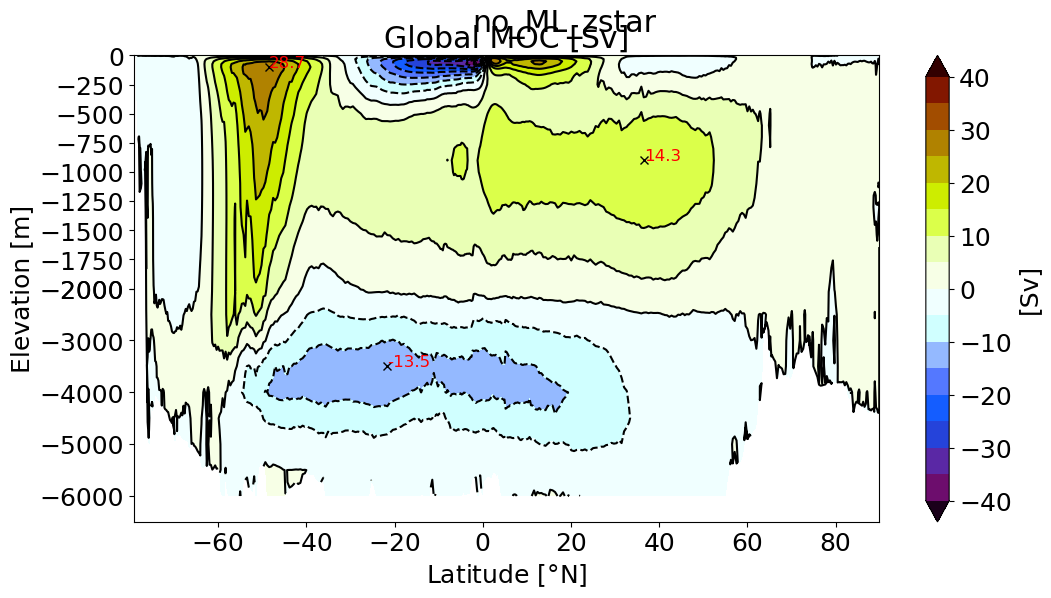

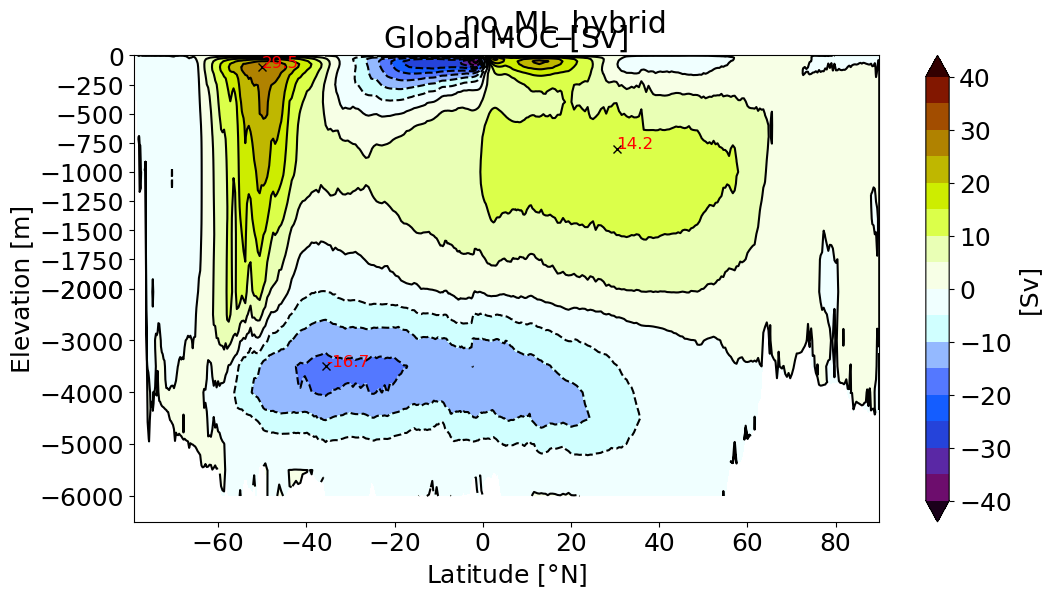

In [7]:
pnum = len(ds)
for i in range(pnum):
  m6plot.setFigureSize([16,9],576,debug=False)
  axis = plt.gca()
  cmap = plt.get_cmap('dunnePM')
  zg = Zmod.min(axis=-1); 
  psiPlot = ds[i].moc.values
  yyg = grd.geolat_c[:,:].max(axis=-1)+0*zg

  ci=m6plot.pmCI(0.,40.,5.)
  plotPsi(yyg, zg, psiPlot, ci, 'Global MOC [Sv]')
  plt.xlabel(r'Latitude [$\degree$N]')
  plt.suptitle(label[i])

  findExtrema(yyg, zg, psiPlot, max_lat=-30.)
  findExtrema(yyg, zg, psiPlot, min_lat=25., min_depth=250.)
  findExtrema(yyg, zg, psiPlot, min_depth=2000., mult=-1.)
  plt.gca().invert_yaxis()


### Atlantic MOC

In [8]:
basin_code = genBasinMasks(grd.geolon, grd.geolat, depth, xda=False);

11.16428 64.78855 [391, 434]


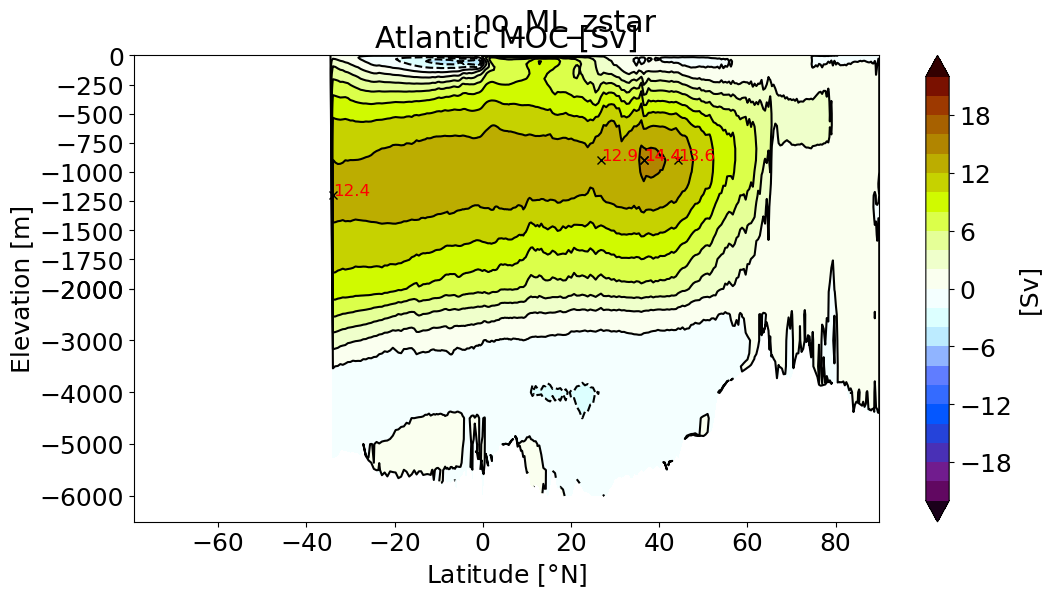

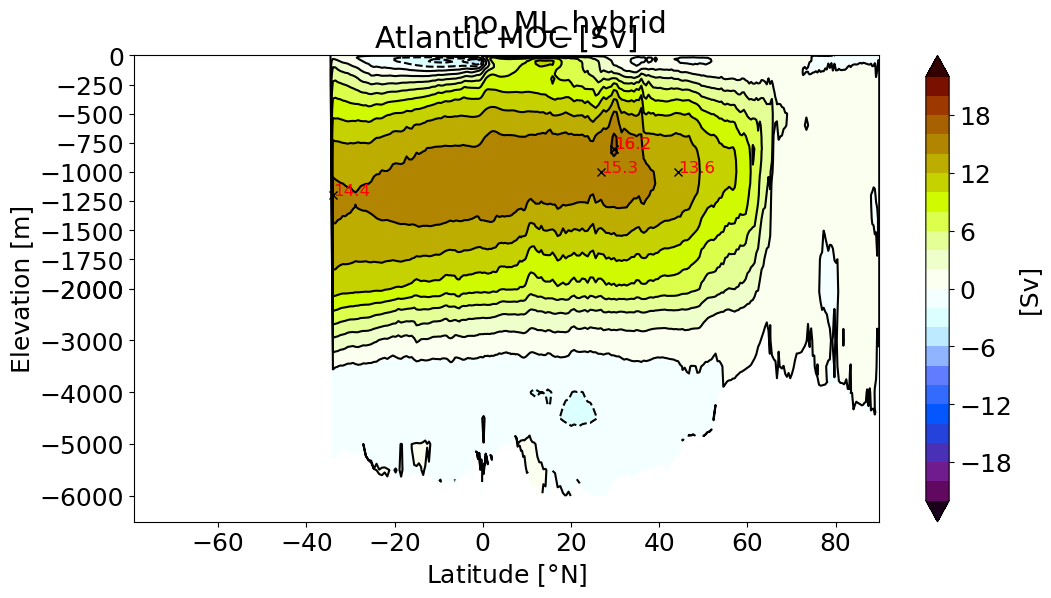

In [9]:
for i in range(pnum):
  m6plot.setFigureSize([16,9],576,debug=False)
  cmap = plt.get_cmap('dunnePM')
  ci=m6plot.pmCI(0.,22.,2.)
  m = 0*basin_code; m[(basin_code==2) | (basin_code==4) | (basin_code==6) | (basin_code==7) | (basin_code==8)]=1
  z = (m*Zmod).min(axis=-1)
  psiPlot = ds[i].amoc.values
  yy = grd.geolat_c[:,:].max(axis=-1)+0*z
  plotPsi(yy, z, psiPlot, ci, 'Atlantic MOC [Sv]')
  plt.xlabel(r'Latitude [$\degree$N]')
  plt.suptitle(label[i])
  findExtrema(yy, z, psiPlot, min_lat=26.5, max_lat=27., min_depth=250.) # RAPID
  findExtrema(yy, z, psiPlot, min_lat=44, max_lat=46., min_depth=250.) # RAPID
  findExtrema(yy, z, psiPlot, max_lat=-33.)
  findExtrema(yy, z, psiPlot)
  findExtrema(yy, z, psiPlot, min_lat=5.)
  plt.gca().invert_yaxis()

### AMOC profile at 26N

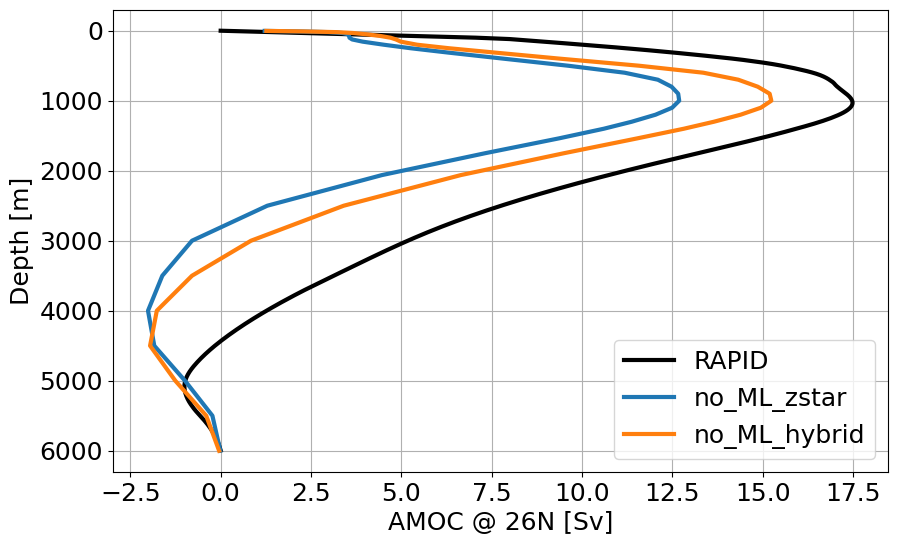

In [10]:
fig, ax = plt.subplots(figsize=(10,6))
rapid_vertical = xr.open_dataset('/glade/work/gmarques/cesm/datasets/RAPID/moc_vertical.nc')
ax.plot(rapid_vertical.stream_function_mar.mean('time'),
        rapid_vertical.depth, 'k', label='RAPID', lw=3)
for i in range(pnum):
  ax.plot(ds[i]['amoc'].sel(yq=26, method='nearest'), ds[i].zl, label=label[i], lw=3)

ax.legend()
plt.gca().invert_yaxis()
plt.grid()
ax.set_xlabel('AMOC @ 26N [Sv]')
ax.set_ylabel('Depth [m]');

### AMOC time series

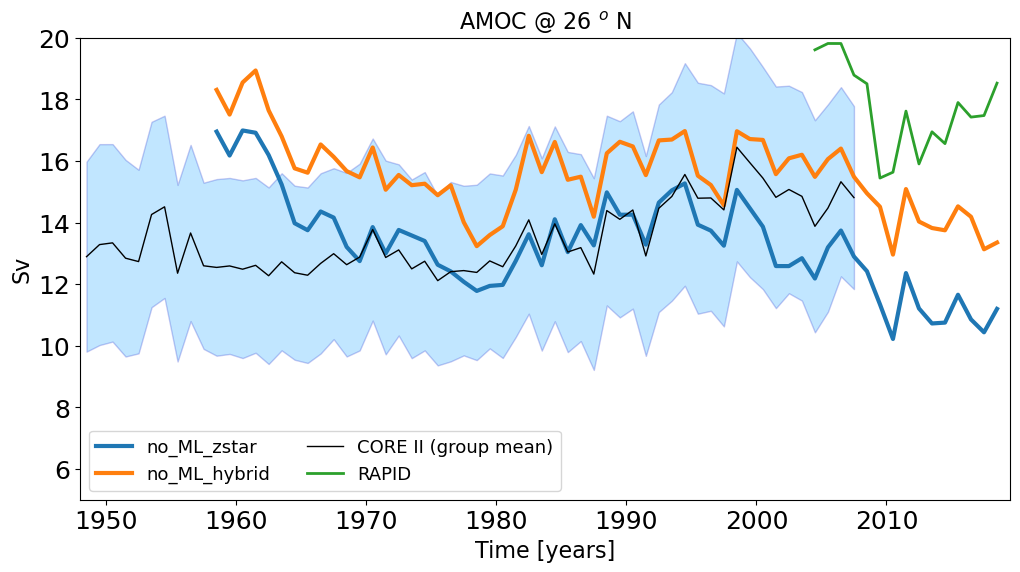

In [11]:
# load AMOC time series data (5th) cycle used in Danabasoglu et al., doi:10.1016/j.ocemod.2015.11.007
path = '/glade/p/cesm/omwg/amoc/COREII_AMOC_papers/papers/COREII.variability/data.original/'
amoc_core_26 = xr.open_dataset(path+'AMOCts.cyc5.26p5.nc')
# load AMOC from POP JRA-55
#amoc_pop_26 = xr.open_dataset('/glade/u/home/bryan/MOM6-modeloutputanalysis/'
#                              'AMOC_series_26n.g210.GIAF_JRA.v13.gx1v7.01.nc') 
# load RAPID time series
rapid = xr.open_dataset('/glade/work/gmarques/cesm/datasets/RAPID/moc_transports.nc').resample(time="1Y", 
                            closed='left',keep_attrs=True).mean('time',keep_attrs=True)

# plot
fig = plt.figure(figsize=(12, 6))
for i in range(pnum):
  plt.plot(np.arange(len(ds[i].time))+1958.5 ,ds[i]['amoc_26'].values, 
           label=label[i], lw=3)
# core data
core_mean = amoc_core_26['MOC'].mean(axis=0).data
core_std = amoc_core_26['MOC'].std(axis=0).data
plt.plot(amoc_core_26.time,core_mean, label='CORE II (group mean)', 
         color='black', lw=1)
plt.fill_between(amoc_core_26.time, core_mean-core_std, core_mean+core_std,
  alpha=0.25, edgecolor='#1B2ACC', facecolor='#089FFF')
# pop data
#plt.plot(np.arange(len(amoc_pop_26.time))+1958.5 ,amoc_pop_26.AMOC_26n.values, 
#         label='POP', lw=2)
# rapid
plt.plot(np.arange(len(rapid.time))+2004.5 ,rapid.moc_mar_hc10.values, 
         label='RAPID', lw=2)

plt.title('AMOC @ 26 $^o$ N', fontsize=16)
plt.ylim(5,20)
plt.xlim(1948,1958.5+len(ds[0].time))
plt.xlabel('Time [years]', fontsize=16); plt.ylabel('Sv', fontsize=16)
plt.legend(fontsize=13, ncol=2);

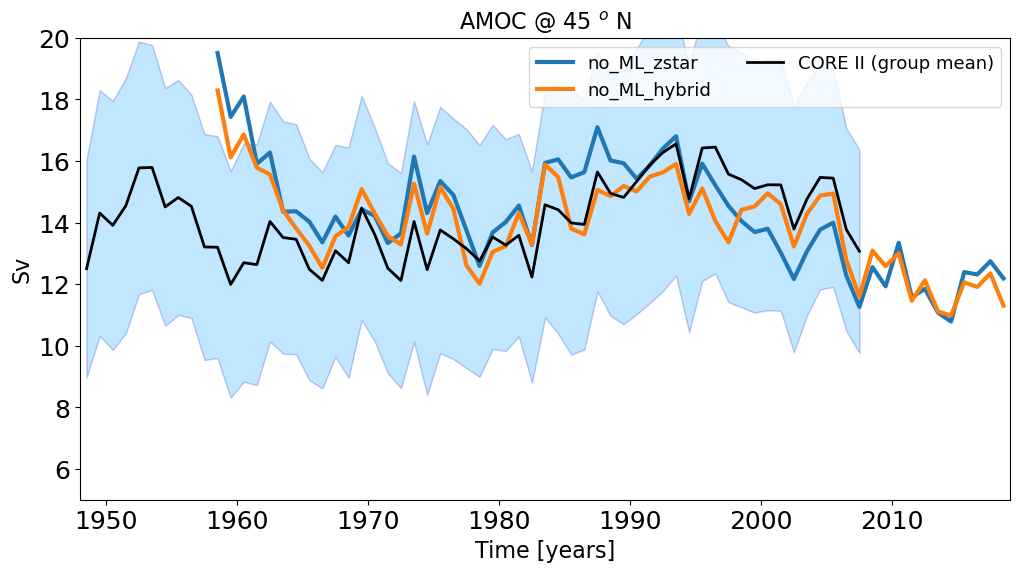

In [12]:
amoc_core_45 = xr.open_dataset(path+'AMOCts.cyc5.45.nc')
#amoc_pop_45 = xr.open_dataset('/glade/u/home/bryan/MOM6-modeloutputanalysis/'
#                              'AMOC_series_45n.g210.GIAF_JRA.v13.gx1v7.01.nc')

# plot
fig = plt.figure(figsize=(12, 6))
for i in range(pnum):
  plt.plot(np.arange(len(ds[i].time))+1958.5 ,ds[i]['amoc_45'].values, 
           label=label[i], lw=3)
# core data
core_mean = amoc_core_45['MOC'].mean(axis=0).data
core_std = amoc_core_45['MOC'].std(axis=0).data
plt.plot(amoc_core_45.time,core_mean, label='CORE II (group mean)', 
         color='black', lw=2)
plt.fill_between(amoc_core_45.time, core_mean-core_std, core_mean+core_std,
  alpha=0.25, edgecolor='#1B2ACC', facecolor='#089FFF')
# pop data
#plt.plot(np.arange(len(amoc_pop_45.time))+1958. ,
#         amoc_pop_45.AMOC_45n.values, label='POP', lw=2)

plt.title('AMOC @ 45 $^o$ N', fontsize=16)
plt.ylim(5,20)
plt.xlim(1948,1958+len(ds[0].time))
plt.xlabel('Time [years]', fontsize=16); plt.ylabel('Sv', fontsize=16)
plt.legend(fontsize=13, ncol=2);

### Submesoscale-induced Global MOC

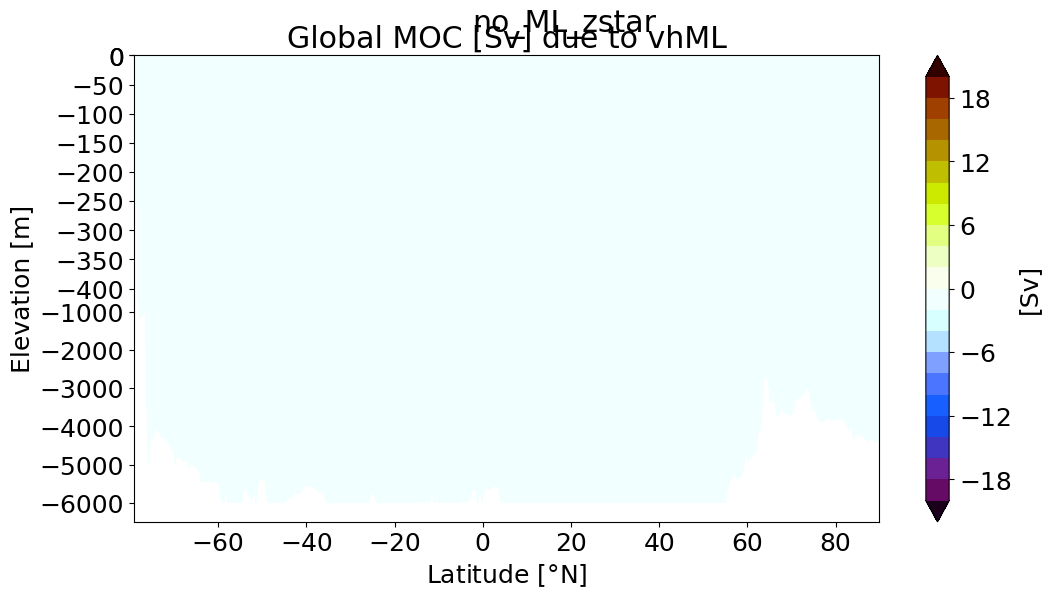

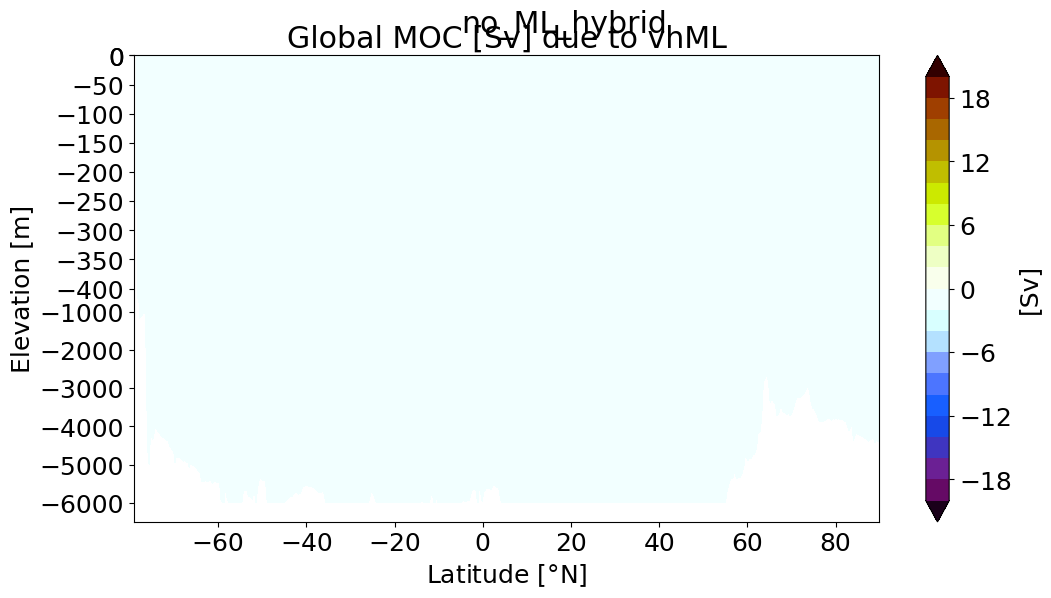

In [13]:
for i in range(pnum):
  m6plot.setFigureSize([16,9],576,debug=False)
  axis = plt.gca()
  cmap = plt.get_cmap('dunnePM')
  z = Zmod.min(axis=-1); 
  psiPlot = ds[i].moc_FFM.values
  #yy = y[1:,:].max(axis=-1)+0*z
  yy = grd.geolat_c[:,:].max(axis=-1)+0*z
  ci=m6plot.pmCI(0.,20.,2.)
  plotPsi(yy, z, psiPlot, ci, 'Global MOC [Sv] due to vhML', zval=[0.,-400.,-6500.])
  plt.xlabel(r'Latitude [$\degree$N]')
  plt.suptitle(label[i])
  plt.gca().invert_yaxis()

#### Eddy(GM)-induced Global MOC

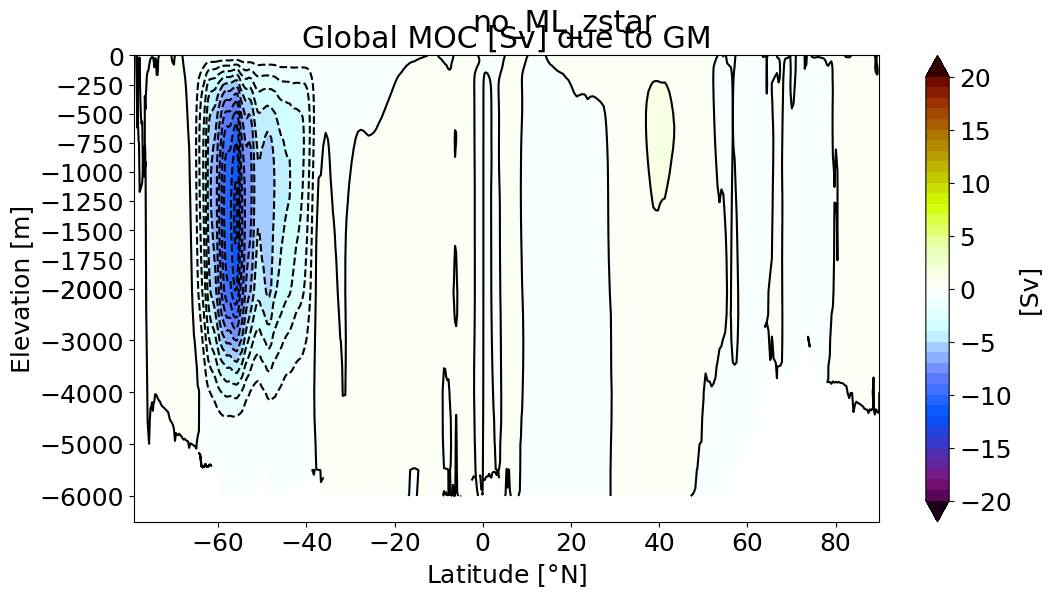

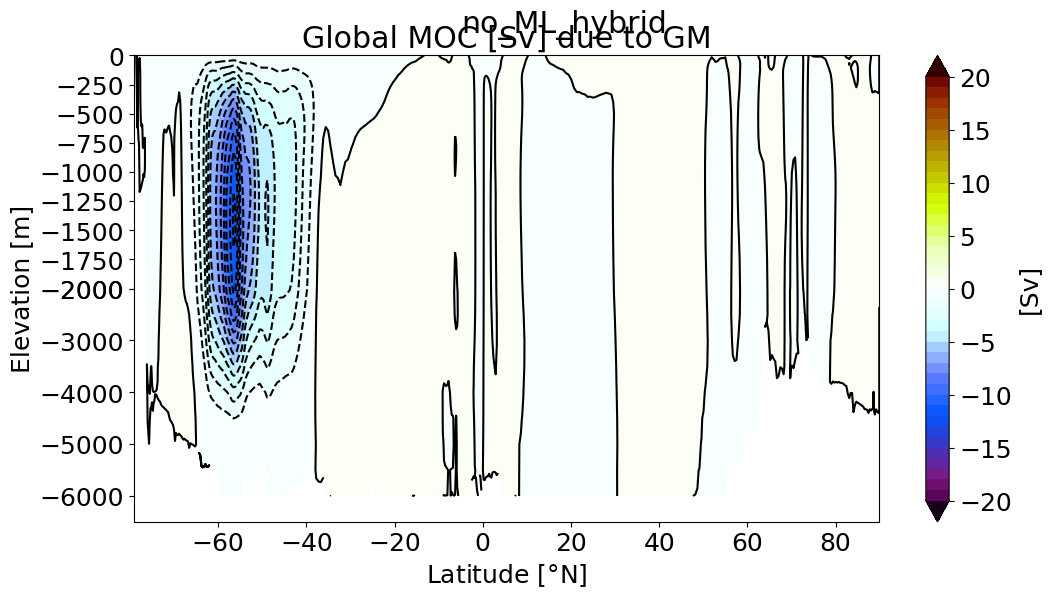

In [14]:
for i in range(pnum):
  m6plot.setFigureSize([16,9],576,debug=False)
  axis = plt.gca()
  cmap = plt.get_cmap('dunnePM')
  z = Zmod.min(axis=-1); 
  psiPlot = ds[i].moc_GM
  yy = grd.geolat_c[:,:].max(axis=-1)+0*z
  ci=m6plot.pmCI(0.,20.,1.)
  plotPsi(yy, z, psiPlot, ci, 'Global MOC [Sv] due to GM')
  plt.xlabel(r'Latitude [$\degree$N]')
  plt.suptitle(label[i])
  plt.gca().invert_yaxis()
